# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


[38029 17486 24158 20256 33421 31207 35528]
[10711 29763 12451 29905 41063  6121 43861]
[24019 16416 13177  6963 34262  3297   646]
[22413 42129 27020 48007 11938 16154 48443]
[49204 37928   434 13310 22183 36968 47318]
[49980 48189 20315 37059 40503 42818 11899]
[44274 37796 40302  1403  8069 29253 12526]
[12579  3191 44278 34010 43625 44000 34708]
[45815 33533  2817 13694 19530 22440 43344]
[49238 30161 29978   881 11085  5861  4675]


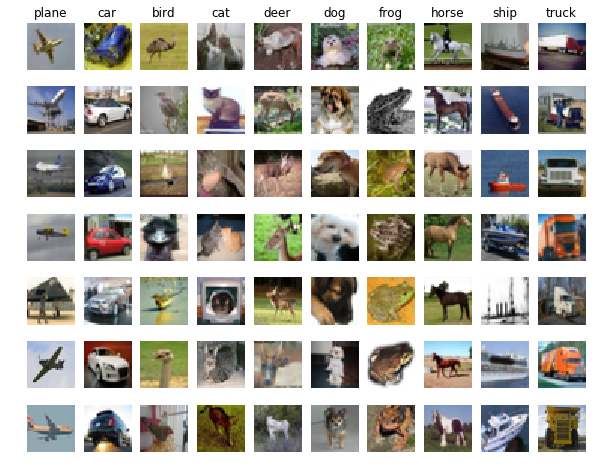

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    print(idxs)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [5]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [6]:
from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [7]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

[ 3803.92350081  4210.59603857  5504.0544147  ...,  4007.64756434
  4203.28086142  4354.20256764]
[ 6336.83367306  5270.28006846  4040.63608854 ...,  4829.15334194
  4694.09767687  7768.33347636]
[ 5224.83913628  4250.64289255  3773.94581307 ...,  3766.81549853
  4464.99921613  6353.57190878]
[ 5265.83754022  4274.49459001  4593.32254474 ...,  4379.85913015
  3793.64455372  6973.20378305]
[ 3163.80277514  4231.52395716  6134.35889071 ...,  4178.39071893
  3972.60292504  3877.14405201]
[ 3072.51281527  4256.22179873  5351.42317519 ...,  3754.21416544
  4142.64854894  3646.74608384]
[ 4184.89462233  5506.63908387  6925.23934604 ...,  5038.19074669
  5926.91209653  4746.98883504]
[ 3356.5065172   4486.25757174  5965.07007503 ...,  4332.44169032
  4558.70990523  3726.08776064]
[ 4473.69858171  4363.13579894  5621.05772964 ...,  4681.63112601
  3155.1476986   6142.73107013]
[ 5739.62167743  4728.38555958  3968.28476801 ...,  4002.40752548
  4012.45274115  6834.87198124]
[ 4058.38859648  350

[ 6325.78872553  5204.58201972  5109.50095411 ...,  5266.6387763
  3783.6118987   7696.19834724]
[ 5152.01853646  5099.68410786  4005.02334575 ...,  3832.87281292
  4596.83662968  5222.30973804]
[ 5045.3214962   4844.92394161  5557.41774568 ...,  4913.83780766
  5222.08646041  4929.05782072]
[ 6754.31891459  5330.86981646  4532.39594475 ...,  5201.2926278
  4644.08957709  8273.5453102 ]
[ 5887.95550255  5099.76401415  3780.54295042 ...,  4486.54488443
  4023.97117286  7366.22141943]
[ 4482.22121275  4192.79429498  4170.05611473 ...,  3369.6667491
  3695.37210576  5330.27400797]
[ 4168.97349476  3680.52971731  5076.74708844 ...,  3704.31788593
  3654.34481132  5400.47590496]
[ 3170.1892688   4747.643942    5913.72327726 ...,  4147.72431581
  4573.78486595  3640.86253517]
[ 6382.8256282   4955.39060014  4972.46035681 ...,  5162.5838492
  4463.0284561   8020.21502206]
[ 4916.61763817  4754.31214793  4070.25846845 ...,  3582.5055478
  3923.12592202  5646.34864315]
[ 3397.22533842  4439.024

[ 5203.22121383  5117.13923985  4657.45466967 ...,  4011.36959155
  3476.01251436  6389.15996043]
[ 5576.06868681  4956.84405645  3185.94052047 ...,  3608.84843129
  4475.64520488  6525.69505877]
[ 5135.76274764  4645.99332759  5278.89363409 ...,  4513.89033983
  3875.15638394  6839.00380172]
[ 5658.26236578  5166.3658407   3978.55878428 ...,  4233.03886115
  3740.87142254  6640.96551715]
[ 4034.71510766  3841.6841359   4318.30672834 ...,  3338.05946622
  2797.6776083   4871.78139904]
[ 4432.733017    4492.61605304  5256.07943243 ...,  4043.79042484
  4808.24562601  5171.9706109 ]
[ 4176.30267102  4676.69744585  5201.77979157 ...,  3815.75615049
  4347.93836203  4062.26291616]
[ 6191.71866286  5532.43897391  4565.94623271 ...,  4934.86585431
  4879.95922114  6242.17205787]
[ 5023.74551505  4739.7419761   5695.58706368 ...,  4492.52913179
  4395.17041763  5042.98671424]
[ 3637.60044535  4690.8464055   4953.25892721 ...,  3623.27282991
  3722.64704209  4754.28385774]
[ 3554.09636898  416

[ 3928.44969422  5123.74765187  5967.72217852 ...,  4725.9005491
  4555.20965489  5270.35871644]
[ 3734.21075999  5241.00496088  5909.36282521 ...,  4258.65319086
  5436.64749639  4042.08510549]
[ 4006.12593412  4150.64043251  4178.16179677 ...,  3109.4214896
  3124.90687861  4687.88150448]
[ 5108.58268016  4435.63028216  4243.58103493 ...,  3871.96513414
  3105.74226233  5810.02022372]
[ 3168.15782435  4322.88526334  5733.56006335 ...,  4043.45063034
  4649.74106806  4453.5332041 ]
[ 6684.82617575  5263.96219591  4932.23174638 ...,  5193.93415438
  5343.36158237  8301.43451459]
[ 5499.56125523  4527.64210158  3719.64581647 ...,  3902.21872785
  3998.95686398  6852.33332523]
[ 4721.52676578  5916.51755681  7029.17292432 ...,  5684.12297545
  5255.01332063  5091.51342923]
[ 3799.7592029   4417.32849129  6486.69985432 ...,  4543.41446492
  4863.73333973  5342.00056159]
[ 4379.40144312  4436.70869001  5478.04198597 ...,  3923.59885819
  4838.31551266  5313.94966103]
[ 4434.08333255  5216.

[ 3557.49518622  4577.93588859  5061.87208452 ...,  3589.42404851
  3947.19013983  4514.51968652]
[ 4938.82749243  3984.37623725  3823.57502869 ...,  3479.82442086
  4176.11194773  5962.45511514]
[ 6558.89769702  5360.06865628  5095.35415845 ...,  5243.54479336
  3986.5976722   7450.44461761]
[ 4425.85584944  5145.92761317  4653.42658694 ...,  4111.82088618
  3689.01179179  5390.82220074]
[ 3254.75744104  3961.63539463  5850.97026142 ...,  4027.66818395
  3021.70481682  4633.71621919]
[ 3824.24345459  4410.30055665  5588.56645304 ...,  4237.93404857
  4175.33591463  4681.11482448]
[ 5209.93234121  4241.86020515  5047.45876655 ...,  4351.72218782
  3225.29456019  6075.34994877]
[ 3693.90227267  4066.19515026  6244.59438234 ...,  4579.62607644
  3699.56267686  4877.19673583]
[ 4341.74676829  3995.94018974  4454.90920222 ...,  3539.37762891
  4509.58213142  4925.35125651]
[ 4260.28625799  5185.82491027  5997.73057081 ...,  4608.86949262
  5295.42113528  4479.2263841 ]
[ 4847.0687018   505

[ 4521.7278777   6190.40531791  7458.16358094 ...,  5820.65546137
  6806.69853894  3818.62815681]
[ 4104.19638906  4741.72827142  6200.63375793 ...,  4603.40189425
  3680.72655871  4877.53790349]
[ 4530.61143776  4251.19148004  3883.55648858 ...,  3472.85545337
  3322.78347173  5620.61437923]
[ 4337.02271149  5904.29530088  7385.54392039 ...,  5553.82309765
  6795.3180941   4240.34857058]
[ 3327.92623115  3796.66037459  4794.06257781 ...,  3378.29779623
  2132.86028609  4807.98284107]
[ 5871.32497823  4631.31989826  4561.92875876 ...,  4315.8408219
  4461.43015187  6828.54120585]
[ 3739.49087444  4542.45869546  6410.5275134  ...,  4644.80989923
  5043.21980485  4414.12029741]
[ 3282.58952658  4312.3630413   5683.83893157 ...,  4082.53315969
  3806.77947877  3794.92608624]
[ 4093.42582686  4126.27943794  5341.04914787 ...,  3702.32035351
  4539.56749041  4830.8559283 ]
[ 6769.72480977  6164.92327608  6008.04951711 ...,  5537.70539122
  4572.47438484  7513.75472051]
[ 3993.69903723  4392

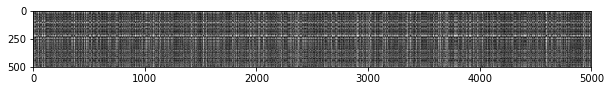

In [8]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question #1:** Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

**Your Answer**: *The distinctly bright rows show that the test image is different from most of train images.*
*The columns indicate that the train image looks same compared with the test images.*



In [9]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)
print(y_test_pred)
# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

[ 4.  9.  8.  8.  4.  4.  3.  2.  5.  8.  2.  8.  5.  7.  2.  2.  5.  3.
  1.  4.  2.  0.  0.  6.  2.  4.  2.  7.  2.  6.  6.  2.  4.  6.  8.  7.
  2.  8.  4.  2.  8.  6.  2.  4.  9.  0.  5.  0.  4.  2.  7.  8.  4.  3.
  8.  8.  5.  0.  0.  4.  4.  6.  6.  3.  3.  2.  8.  8.  3.  9.  2.  4.
  8.  0.  4.  4.  6.  3.  6.  8.  8.  3.  5.  0.  7.  4.  3.  8.  8.  8.
  0.  4.  8.  1.  4.  0.  6.  0.  0.  8.  4.  7.  6.  4.  1.  1.  4.  6.
  5.  5.  4.  0.  3.  0.  4.  4.  2.  2.  4.  6.  8.  4.  4.  6.  8.  2.
  0.  2.  6.  2.  2.  1.  0.  6.  6.  5.  9.  0.  2.  8.  2.  2.  6.  5.
  8.  4.  2.  5.  5.  8.  0.  3.  6.  0.  8.  4.  8.  8.  5.  4.  0.  4.
  6.  4.  8.  0.  8.  6.  5.  0.  8.  7.  8.  8.  4.  4.  0.  4.  4.  8.
  8.  0.  2.  4.  0.  0.  6.  3.  8.  8.  3.  4.  2.  2.  4.  4.  8.  8.
  4.  2.  2.  4.  8.  2.  4.  2.  0.  2.  6.  0.  6.  2.  2.  2.  8.  2.
  0.  9.  0.  4.  7.  4.  7.  0.  3.  6.  2.  2.  4.  4.  3.  1.  2.  3.
  8.  2.  4.  9.  5.  5.  0.  4.  4.  0.  2.  2.  6

You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [10]:
y_test_pred = classifier.predict_labels(dists, k=5)
print(y_test_pred)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

[ 4.  8.  8.  8.  4.  6.  6.  2.  2.  8.  0.  8.  5.  6.  8.  2.  5.  4.
  8.  2.  2.  0.  0.  4.  2.  4.  2.  7.  2.  2.  6.  2.  4.  6.  8.  7.
  2.  0.  2.  2.  8.  6.  2.  4.  0.  0.  5.  0.  4.  2.  8.  8.  4.  2.
  8.  8.  5.  6.  0.  0.  4.  6.  6.  3.  4.  2.  8.  2.  3.  9.  2.  6.
  8.  8.  0.  4.  2.  3.  6.  8.  8.  3.  6.  0.  2.  8.  2.  8.  8.  8.
  0.  2.  8.  6.  4.  2.  4.  0.  0.  4.  4.  4.  6.  4.  4.  1.  6.  6.
  5.  5.  4.  0.  6.  0.  4.  4.  2.  8.  4.  4.  8.  4.  2.  6.  8.  4.
  0.  2.  4.  2.  2.  1.  8.  6.  6.  2.  9.  0.  2.  8.  2.  2.  6.  2.
  8.  2.  6.  5.  5.  8.  0.  3.  2.  0.  4.  4.  0.  8.  5.  8.  0.  4.
  6.  4.  0.  0.  8.  2.  5.  0.  8.  7.  2.  8.  4.  4.  0.  4.  6.  0.
  8.  4.  2.  4.  0.  0.  6.  6.  8.  8.  3.  4.  2.  3.  4.  2.  8.  0.
  4.  2.  2.  0.  8.  2.  8.  4.  0.  2.  2.  8.  4.  8.  2.  4.  8.  2.
  0.  9.  0.  4.  6.  4.  8.  0.  3.  7.  4.  2.  4.  4.  3.  1.  2.  4.
  0.  2.  4.  9.  0.  5.  0.  8.  8.  0.  2.  4.  4

You should expect to see a slightly better performance than with `k = 1`.

In [15]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)
print(dists_one)
# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

[[ 3803.92350081  4210.59603857  5504.0544147  ...,  4007.64756434
   4203.28086142  4354.20256764]
 [ 6336.83367306  5270.28006846  4040.63608854 ...,  4829.15334194
   4694.09767687  7768.33347636]
 [ 5224.83913628  4250.64289255  3773.94581307 ...,  3766.81549853
   4464.99921613  6353.57190878]
 ..., 
 [ 5366.93534524  5062.8772452   6361.85774755 ...,  5126.56824786
   4537.30613911  5920.94156364]
 [ 3671.92919322  3858.60765044  4846.88157479 ...,  3521.04515734
   3182.3673578   4448.65305458]
 [ 6960.92443573  6083.71366848  6338.13442584 ...,  6083.55504619
   4128.24744898  8041.05223214]]
Difference was: 0.000000
Good! The distance matrices are the same


In [14]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)
print(dists_two)
# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

[[ 3803.92350081  4210.59603857  5504.0544147  ...,  4007.64756434
   4203.28086142  4354.20256764]
 [ 6336.83367306  5270.28006846  4040.63608854 ...,  4829.15334194
   4694.09767687  7768.33347636]
 [ 5224.83913628  4250.64289255  3773.94581307 ...,  3766.81549853
   4464.99921613  6353.57190878]
 ..., 
 [ 5366.93534524  5062.8772452   6361.85774755 ...,  5126.56824786
   4537.30613911  5920.94156364]
 [ 3671.92919322  3858.60765044  4846.88157479 ...,  3521.04515734
   3182.3673578   4448.65305458]
 [ 6960.92443573  6083.71366848  6338.13442584 ...,  6083.55504619
   4128.24744898  8041.05223214]]
Difference was: 0.000000
Good! The distance matrices are the same


In [16]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# you should see significantly faster performance with the fully vectorized implementation

[ 3803.92350081  4210.59603857  5504.0544147  ...,  4007.64756434
  4203.28086142  4354.20256764]
[ 6336.83367306  5270.28006846  4040.63608854 ...,  4829.15334194
  4694.09767687  7768.33347636]
[ 5224.83913628  4250.64289255  3773.94581307 ...,  3766.81549853
  4464.99921613  6353.57190878]
[ 5265.83754022  4274.49459001  4593.32254474 ...,  4379.85913015
  3793.64455372  6973.20378305]
[ 3163.80277514  4231.52395716  6134.35889071 ...,  4178.39071893
  3972.60292504  3877.14405201]
[ 3072.51281527  4256.22179873  5351.42317519 ...,  3754.21416544
  4142.64854894  3646.74608384]
[ 4184.89462233  5506.63908387  6925.23934604 ...,  5038.19074669
  5926.91209653  4746.98883504]
[ 3356.5065172   4486.25757174  5965.07007503 ...,  4332.44169032
  4558.70990523  3726.08776064]
[ 4473.69858171  4363.13579894  5621.05772964 ...,  4681.63112601
  3155.1476986   6142.73107013]
[ 5739.62167743  4728.38555958  3968.28476801 ...,  4002.40752548
  4012.45274115  6834.87198124]
[ 4058.38859648  350

[ 6325.78872553  5204.58201972  5109.50095411 ...,  5266.6387763
  3783.6118987   7696.19834724]
[ 5152.01853646  5099.68410786  4005.02334575 ...,  3832.87281292
  4596.83662968  5222.30973804]
[ 5045.3214962   4844.92394161  5557.41774568 ...,  4913.83780766
  5222.08646041  4929.05782072]
[ 6754.31891459  5330.86981646  4532.39594475 ...,  5201.2926278
  4644.08957709  8273.5453102 ]
[ 5887.95550255  5099.76401415  3780.54295042 ...,  4486.54488443
  4023.97117286  7366.22141943]
[ 4482.22121275  4192.79429498  4170.05611473 ...,  3369.6667491
  3695.37210576  5330.27400797]
[ 4168.97349476  3680.52971731  5076.74708844 ...,  3704.31788593
  3654.34481132  5400.47590496]
[ 3170.1892688   4747.643942    5913.72327726 ...,  4147.72431581
  4573.78486595  3640.86253517]
[ 6382.8256282   4955.39060014  4972.46035681 ...,  5162.5838492
  4463.0284561   8020.21502206]
[ 4916.61763817  4754.31214793  4070.25846845 ...,  3582.5055478
  3923.12592202  5646.34864315]
[ 3397.22533842  4439.024

[ 5203.22121383  5117.13923985  4657.45466967 ...,  4011.36959155
  3476.01251436  6389.15996043]
[ 5576.06868681  4956.84405645  3185.94052047 ...,  3608.84843129
  4475.64520488  6525.69505877]
[ 5135.76274764  4645.99332759  5278.89363409 ...,  4513.89033983
  3875.15638394  6839.00380172]
[ 5658.26236578  5166.3658407   3978.55878428 ...,  4233.03886115
  3740.87142254  6640.96551715]
[ 4034.71510766  3841.6841359   4318.30672834 ...,  3338.05946622
  2797.6776083   4871.78139904]
[ 4432.733017    4492.61605304  5256.07943243 ...,  4043.79042484
  4808.24562601  5171.9706109 ]
[ 4176.30267102  4676.69744585  5201.77979157 ...,  3815.75615049
  4347.93836203  4062.26291616]
[ 6191.71866286  5532.43897391  4565.94623271 ...,  4934.86585431
  4879.95922114  6242.17205787]
[ 5023.74551505  4739.7419761   5695.58706368 ...,  4492.52913179
  4395.17041763  5042.98671424]
[ 3637.60044535  4690.8464055   4953.25892721 ...,  3623.27282991
  3722.64704209  4754.28385774]
[ 3554.09636898  416

[ 3928.44969422  5123.74765187  5967.72217852 ...,  4725.9005491
  4555.20965489  5270.35871644]
[ 3734.21075999  5241.00496088  5909.36282521 ...,  4258.65319086
  5436.64749639  4042.08510549]
[ 4006.12593412  4150.64043251  4178.16179677 ...,  3109.4214896
  3124.90687861  4687.88150448]
[ 5108.58268016  4435.63028216  4243.58103493 ...,  3871.96513414
  3105.74226233  5810.02022372]
[ 3168.15782435  4322.88526334  5733.56006335 ...,  4043.45063034
  4649.74106806  4453.5332041 ]
[ 6684.82617575  5263.96219591  4932.23174638 ...,  5193.93415438
  5343.36158237  8301.43451459]
[ 5499.56125523  4527.64210158  3719.64581647 ...,  3902.21872785
  3998.95686398  6852.33332523]
[ 4721.52676578  5916.51755681  7029.17292432 ...,  5684.12297545
  5255.01332063  5091.51342923]
[ 3799.7592029   4417.32849129  6486.69985432 ...,  4543.41446492
  4863.73333973  5342.00056159]
[ 4379.40144312  4436.70869001  5478.04198597 ...,  3923.59885819
  4838.31551266  5313.94966103]
[ 4434.08333255  5216.

[ 3557.49518622  4577.93588859  5061.87208452 ...,  3589.42404851
  3947.19013983  4514.51968652]
[ 4938.82749243  3984.37623725  3823.57502869 ...,  3479.82442086
  4176.11194773  5962.45511514]
[ 6558.89769702  5360.06865628  5095.35415845 ...,  5243.54479336
  3986.5976722   7450.44461761]
[ 4425.85584944  5145.92761317  4653.42658694 ...,  4111.82088618
  3689.01179179  5390.82220074]
[ 3254.75744104  3961.63539463  5850.97026142 ...,  4027.66818395
  3021.70481682  4633.71621919]
[ 3824.24345459  4410.30055665  5588.56645304 ...,  4237.93404857
  4175.33591463  4681.11482448]
[ 5209.93234121  4241.86020515  5047.45876655 ...,  4351.72218782
  3225.29456019  6075.34994877]
[ 3693.90227267  4066.19515026  6244.59438234 ...,  4579.62607644
  3699.56267686  4877.19673583]
[ 4341.74676829  3995.94018974  4454.90920222 ...,  3539.37762891
  4509.58213142  4925.35125651]
[ 4260.28625799  5185.82491027  5997.73057081 ...,  4608.86949262
  5295.42113528  4479.2263841 ]
[ 4847.0687018   505

[ 4521.7278777   6190.40531791  7458.16358094 ...,  5820.65546137
  6806.69853894  3818.62815681]
[ 4104.19638906  4741.72827142  6200.63375793 ...,  4603.40189425
  3680.72655871  4877.53790349]
[ 4530.61143776  4251.19148004  3883.55648858 ...,  3472.85545337
  3322.78347173  5620.61437923]
[ 4337.02271149  5904.29530088  7385.54392039 ...,  5553.82309765
  6795.3180941   4240.34857058]
[ 3327.92623115  3796.66037459  4794.06257781 ...,  3378.29779623
  2132.86028609  4807.98284107]
[ 5871.32497823  4631.31989826  4561.92875876 ...,  4315.8408219
  4461.43015187  6828.54120585]
[ 3739.49087444  4542.45869546  6410.5275134  ...,  4644.80989923
  5043.21980485  4414.12029741]
[ 3282.58952658  4312.3630413   5683.83893157 ...,  4082.53315969
  3806.77947877  3794.92608624]
[ 4093.42582686  4126.27943794  5341.04914787 ...,  3702.32035351
  4539.56749041  4830.8559283 ]
[ 6769.72480977  6164.92327608  6008.04951711 ...,  5537.70539122
  4572.47438484  7513.75472051]
[ 3993.69903723  4392

### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [20]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
X_train_folds = np.array_split(X_train,num_folds)
y_train_folds = np.array_split(y_train,num_folds)
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################

for k in k_choices:
    accuracy = []
    for i in range(num_folds-1):
        classifier.train(X_train_folds[i],y_train_folds[i])
        y_prep = classifier.predict(X_train_folds[-1],k,num_loops=0)
        accuracy.append(float(np.sum(y_prep == y_train_folds[-1]))/y_prep.shape[0])
    k_to_accuracies[k] = accuracy 


################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.245000
k = 1, accuracy = 0.232000
k = 1, accuracy = 0.259000
k = 1, accuracy = 0.227000
k = 3, accuracy = 0.253000
k = 3, accuracy = 0.246000
k = 3, accuracy = 0.259000
k = 3, accuracy = 0.229000
k = 5, accuracy = 0.256000
k = 5, accuracy = 0.258000
k = 5, accuracy = 0.250000
k = 5, accuracy = 0.239000
k = 8, accuracy = 0.261000
k = 8, accuracy = 0.261000
k = 8, accuracy = 0.279000
k = 8, accuracy = 0.245000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.262000
k = 10, accuracy = 0.263000
k = 10, accuracy = 0.244000
k = 12, accuracy = 0.261000
k = 12, accuracy = 0.255000
k = 12, accuracy = 0.270000
k = 12, accuracy = 0.248000
k = 15, accuracy = 0.260000
k = 15, accuracy = 0.255000
k = 15, accuracy = 0.268000
k = 15, accuracy = 0.244000
k = 20, accuracy = 0.265000
k = 20, accuracy = 0.252000
k = 20, accuracy = 0.262000
k = 20, accuracy = 0.248000
k = 50, accuracy = 0.254000
k = 50, accuracy = 0.238000
k = 50, accuracy = 0.263000
k = 50, accuracy = 0.241000
k = 100,

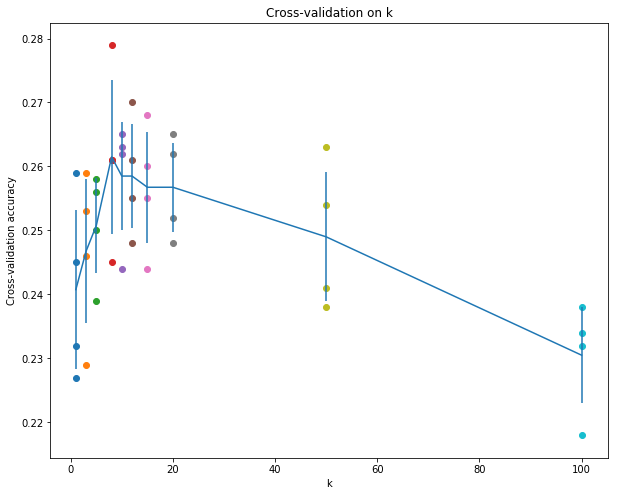

In [21]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [26]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 8

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 147 / 500 correct => accuracy: 0.294000
